<a href="https://colab.research.google.com/github/Taha0229/finetuning_LLM/blob/main/Fine_Tuning_LLM_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tune a Generative AI Model for Dialogue Summarization

In this notebook I have tried improving the performance of the Flan-T5 LLM in our specific use case which is conversation summarization. The objective is to-
1. Perform full instruction fine tuning,
2. Apply PEFT (Paramete Efficient Fine Tuning) techniques:
i.  LoRA
ii. Prompt tuning
3. Evaluate the model's performance

Full fine tuning takes a lot of compute but provides best results, however with a larger model and a decent dataset we can still achieve comparable results with PEFT techniques. More on each techniques in the respective section.

**Note:**
As fine-tunning an LLM takes a lot of compute, I have opted to train a comparatively smaller LLM (Flan-T5; 248M parameters). However, the process for training any larger LLM remains the same.





## 1 - Set up Kernel, Load Required Dependencies, Dataset and LLM

### 1.1 - Set up Kernel and Required Dependencies

In [ ]:
%pip install -U datasets==2.17.0

%pip install --upgrade pip \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    peft==0.3.0 --quiet

Import the required components.

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np

### 1.2 - Load Dataset and LLM

Going with the same dataset as in the previous [notebook](https://colab.research.google.com/github/Taha0229/GenAI_with_LLM/blob/main/Fine_tuning_LLM_part_1.ipynb): [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum). It contains 10,000+ dialogues with the corresponding manually labeled summaries and topics.

In [ ]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

Load the pre-trained [FLAN-T5 model](https://huggingface.co/docs/transformers/model_doc/flan-t5) and its tokenizer directly from HuggingFace. Setting `torch_dtype=torch.bfloat16` specifies the memory type to be used by this model.`bfloat16` will use half of the memory required for the default `bfloat32`.

In [ ]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Pulling out the number of model parameters to check how many of them are trainable.

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


### 1.3 - Test the Model with Zero Shot Inferencing

Testing the model with zero shot inferencing. The model will struggle to summarize the dialogue compared to the baseline summary, but we can use this as reference for later fine-tuned model.

In [ ]:
index = 200

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt') # tokenized the input
output = tokenizer.decode( # decoding the generated tokens from the llm to english
    original_model.generate( # generating the token streams from the llm
        inputs["input_ids"],
        max_new_tokens=200,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Summary:

-------------------------------------------------------------------

## 2 - Perform Full Fine-Tuning

### 2.1 - Preprocess the Dialog-Summary Dataset

Objective: Convert the dialog-summary (prompt-response) pairs into explicit instructions for the LLM.  
Prepend an instruction to the start of the dialog with `Summarize the following conversation` and to the start of the summary with `Summary` as follows:



Training prompt (dialogue):
```
Summarize the following conversation.

    Chris: This is his part of the conversation.
    Antje: This is her part of the conversation.
    
Summary:
```

Training response (summary):
```
Both Chris and Antje participated in the conversation.
```

Then preprocess the prompt-response dataset into tokens and pull out their `input_ids` (1 per token).

In [ ]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets_full = dataset.map(tokenize_function, batched=True)
tokenized_datasets_full = tokenized_datasets_full.remove_columns(['id', 'topic', 'dialogue', 'summary',])

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Shapes of all three parts of the full dataset:

In [ ]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets_full['train'].shape}")
print(f"Validation: {tokenized_datasets_full['validation'].shape}")
print(f"Test: {tokenized_datasets_full['test'].shape}")

print(tokenized_datasets_full)

Shapes of the datasets:
Training: (12460, 2)
Validation: (500, 2)
Test: (1500, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1500
    })
})


To save some time and compute, we can subsample the dataset:

In [ ]:
tokenized_datasets = tokenized_datasets_full.filter(lambda example, index: index % 60 == 0, with_indices=True)

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Shapes of all three parts of the filtered dataset:

In [ ]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (208, 2)
Validation: (9, 2)
Test: (25, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 208
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 9
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 25
    })
})


The output dataset is ready for fine-tuning.

### 2.2 - Fine-Tune the Model with the Preprocessed Dataset

We can utilize the built-in Hugging Face `Trainer` class ([documentation](https://huggingface.co/docs/transformers/main_classes/trainer) ). Pass the preprocessed dataset with reference to the original model. Here, I am using my drive to save the checkpoints, change the `output_dir` to save the model somewhere else.

In [ ]:
# connect to google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Delete a folder
# folder_name = "dialogue-summary-training-1716519001"
# import shutil
# shutil.rmtree(f'/content/{folder_name}')


In [ ]:
# Check a path
import os
path = "./drive/MyDrive/Gen AI - fine tuning/dialogue-summary-training-colab"
os.path.exists(path)

False

In [ ]:

output_dir = f'./drive/MyDrive/Gen AI - fine tuning/dialogue-summary-training-colab'

if not os.path.exists(output_dir):
  print(f"CREATING A DIRECTORY AT {output_dir}")
  os.mkdir(output_dir)

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=100,
    weight_decay=0.01,
    logging_steps=1,
)
training_args = training_args.set_dataloader(train_batch_size=6, eval_batch_size=4)


CREATING A DIRECTORY AT ./drive/MyDrive/Gen AI - fine tuning/dialogue-summary-training-colab


In [ ]:
trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

Access the checkpoint of this training

In [ ]:
# !gdown --folder 115QXW-Fk6wbY9DWc3-77wezpb7pShiPt

###**Quick math before training:**

When using a T4 GPU instance in Google Colab for full instruction fine-tuning, the training_batch_size cannot exceed 6. Through trial and error, I found that to make the most of Colab's free tier, the dataset should be around 200-250 examples due to the available compute time of approximately 2.5 to 3 hours. The default batch size of 8 requires 20.76 GB of VRAM. For further training, I used AWS ml.m5.2xl, which provides 32 GB of VRAM, to train on the full dataset.


Following are the general memory requirements for an LLM (higher end):
  
| Component                       | Memory Required per Parameter |
|---------------------------------|-------------------------------|
| LLM Parameter (float32)         | 4 Bytes                       |
| Adam Optimizer                  | 8 Bytes                       |
| Gradients                       | 4 Bytes                       |
| Activations and Temp Memory     | 8 Bytes                       |

Total no. of parameters in the model = 248 Million  
Following are the specific memory requirements for `google/flan-t5-base` with `bfloat16` and a `batch size` of one:

| Component                       | Memory Required per Parameter |
|---------------------------------|-------------------------------|
| LLM Parameter (float32)         | 850.3 MB or 0.830 GB          |
| Adam Optimizer                  | 1.66 GB * `batch_size`        |
| Back Propagation + Misc         | 0.83 GB * `batch_size`        |
|  Total                          | 3.32 GB (for `batch_size=1`)  |


  
This also motivates us to try out other low compute PEFT strategies.



In [ ]:
op = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,50.000000
2,48.750000
3,51.750000
4,51.000000
5,48.250000
6,48.750000
7,49.000000
8,48.000000
9,51.000000
10,49.500000


In [ ]:
op

TrainOutput(global_step=3500, training_loss=32.90078571428572, metrics={'train_runtime': 8012.6728, 'train_samples_per_second': 2.596, 'train_steps_per_second': 0.437, 'total_flos': 1.42429529309184e+16, 'train_loss': 32.90078571428572, 'epoch': 100.0})

ALternatively, we can download a checkpoint of the fully fine-tuned model from my gdrive or from my huggingface which I had previously trained on AWS SageMaker

In [ ]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("CyberPun/flan-summary-fft")
# model = AutoModelForSeq2SeqLM.from_pretrained("CyberPun/flan-summary-fft")

In [ ]:
!gdown --folder 11wEBTprgRylL-FMFECujbABXl2BF-bar

Retrieving folder contents
Processing file 1_qCS24z62v19iborAMkbtQPy6uHitr9b config.json
Processing file 1FqqeFgZzJJ9Md4ZITgUP6Qs5F9TFs1y_ generation_config.json
Processing file 1-gD1rHef8BGjH780Hlj2lsjmi4O0iTNC optimizer.pt
Processing file 1diYWVq-Y9nW2dWTg3o49hYRDr9-A9YtB pytorch_model.bin
Processing file 1eahqvq77Kam_2y9VTrJyfYIS3TrnErX7 rng_state.pth
Processing file 1oToblQtVdKLPzJA6KwszbzgRIvtKqaj- scheduler.pt
Processing file 1dj9vtNvXL7p2DUa0mqmpB5jM4knjgH4n trainer_state.json
Processing file 1kQXsuAob_SiBYQnZgtngShDUeNG7KlDq training_args.bin
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1_qCS24z62v19iborAMkbtQPy6uHitr9b
To: /content/flan-dialogue-summary-checkpoint/config.json
100% 1.53k/1.53k [00:00<00:00, 7.14MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FqqeFgZzJJ9Md4ZITgUP6Qs5F9TFs1y_
To: /content/flan-dialogue-summary-checkpoint/generation_config.jso

The size of the downloaded instruct model is approximately 1GB.

In [ ]:
!ls -alh ./flan-dialogue-summary-checkpoint/pytorch_model.bin

-rw-r--r-- 1 root root 945M May 17 15:41 ./flan-dialogue-summary-checkpoint/pytorch_model.bin


Create an instance of the `AutoModelForSeq2SeqLM` class for the instruct model:

In [ ]:
instruct_model = AutoModelForSeq2SeqLM.from_pretrained("./flan-dialogue-summary-checkpoint", torch_dtype=torch.bfloat16)

### 2.3 - Evaluate the Model Qualitatively (Human Evaluation)

As with many GenAI applications, a qualitative approach where we ask ourself the question "Is my model behaving the way it is supposed to?" is usually a good starting point. In the example below we can see how the fine-tuned model is able to create a reasonable summary of the dialogue compared to the original inability to understand what is being asked of the model.

In [ ]:
index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
#Person1#: I'm thinking of upgrading my computer.
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
#Person1# suggests #Person2# upgrading #Person2#'s system, hardware, and CD-ROM drive. #Person2# thinks it's great.


### 2.4 - Evaluate the Model Quantitatively (with ROUGE Metric)

The [ROUGE metric](https://en.wikipedia.org/wiki/ROUGE_(metric)) helps quantify the validity of summarizations produced by models. It compares summarizations to a "baseline" summary which is usually created by a human. While not perfect, it does indicate the overall increase in summarization effectiveness that we have accomplished by fine-tuning.

In [ ]:
rouge = evaluate.load('rouge')

Generate the outputs for the sample of the test dataset (only 10 dialogues and summaries to save time), and save the results.

In [ ]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []

for _, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_summaries.append(original_model_text_output)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)
    instruct_model_summaries.append(instruct_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,#Person1#: I need to take a dictation for you.,#Person1# asks Ms. Dawson to take a dictation ...
1,In order to prevent employees from wasting tim...,#Person1#: I need to take a dictation for you.,#Person1# asks Ms. Dawson to take a dictation ...
2,Ms. Dawson takes a dictation for #Person1# abo...,#Person1#: I need to take a dictation for you.,#Person1# asks Ms. Dawson to take a dictation ...
3,#Person2# arrives late because of traffic jam....,The traffic jam at the Carrefour intersection ...,#Person2# got stuck in traffic again. #Person1...
4,#Person2# decides to follow #Person1#'s sugges...,The traffic jam at the Carrefour intersection ...,#Person2# got stuck in traffic again. #Person1...
5,#Person2# complains to #Person1# about the tra...,The traffic jam at the Carrefour intersection ...,#Person2# got stuck in traffic again. #Person1...
6,#Person1# tells Kate that Masha and Hero get d...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...
7,#Person1# tells Kate that Masha and Hero are g...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...
8,#Person1# and Kate talk about the divorce betw...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...
9,#Person1# and Brian are at the birthday party ...,"#Person1#: Happy birthday, Brian. #Person2#: I...",Brian's birthday is coming. #Person1# invites ...


Evaluate the models computing ROUGE metrics. Notice the improvement in the results!

In [ ]:
original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

ORIGINAL MODEL:
{'rouge1': 0.24089921652421653, 'rouge2': 0.11769053708439897, 'rougeL': 0.22001958689458687, 'rougeLsum': 0.22134175465057818}
INSTRUCT MODEL:
{'rouge1': 0.41026607717457186, 'rouge2': 0.17840645241958838, 'rougeL': 0.2977022096267017, 'rougeLsum': 0.2987374187518165}


The file `dialogue-summary-training-results.csv` contains a pre-populated list of all model results which we can use to evaluate on a larger section of data. Let's do that for each of the models:

In [ ]:
# download the csv file from my github repo

!wget https://github.com/Taha0229/finetuning_LLM/blob/main/dialogue-summary-training-results.csv


--2024-05-22 10:45:41--  https://github.com/Taha0229/finetuning_LLM/blob/main/dialogue-summary-training-results.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘dialogue-summary-training-results.csv’

dialogue-summary-tr     [ <=>                ]   2.01M  --.-KB/s    in 0.06s   

2024-05-22 10:45:42 (35.0 MB/s) - ‘dialogue-summary-training-results.csv’ saved [2106621]



In [ ]:
results = pd.read_csv("dialogue-summary-training-results.csv")

human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

The results show substantial improvement in all ROUGE metrics:

In [ ]:
print("Absolute percentage improvement of INSTRUCT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(instruct_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(instruct_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of INSTRUCT MODEL over ORIGINAL MODEL
rouge1: 18.82%
rouge2: 10.43%
rougeL: 13.70%
rougeLsum: 13.69%


## 3 - Perform Parameter Efficient Fine-Tuning (PEFT)

Now, let's perform **Parameter Efficient Fine-Tuning (PEFT)** fine-tuning as opposed to "full fine-tuning" as we did above. PEFT is a form of instruction fine-tuning that is much more efficient than full fine-tuning - with comparable evaluation results.

PEFT is a generic term that includes **Low-Rank Adaptation (LoRA)** and prompt tuning (which is NOT THE SAME as prompt engineering!).

In LoRA we freeze the LLMs weights and inject 2 rank decomposition matrices and only train weights of these smaller matrices. The key aspect here is to choose a rank, r for both of the matrices to perform matrix multiplication. The result of the matmul should be a new matrix with dimensions equal to the `weight` matrix of the LLM. Finally, during inference, the resultant matrix is added to the original weights.
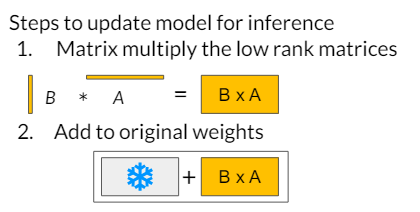



LoRA, at a very high level, allows the user to fine-tune their model using fewer compute resources (in some cases, a single GPU). After fine-tuning for a specific task, use case, or tenant with LoRA, the result is that the original LLM remains unchanged and a newly-trained “LoRA adapter” emerges. This LoRA adapter is much, much smaller than the original LLM - on the order of a single-digit % of the original LLM size (MBs vs GBs).  

That said, at inference time, the LoRA adapter needs to be reunited and combined with its original LLM to serve the inference request.  The benefit, however, is that many LoRA adapters can re-use the original LLM which reduces overall memory requirements when serving multiple tasks and use cases.

### 3.1 - Setup the PEFT/LoRA model for Fine-Tuning

We need to set up the PEFT/LoRA model for fine-tuning with a new layer/parameter adapter. Using PEFT/LoRA, we are freezing the underlying LLM and only training the adapter with the following LoRA configuration below. The rank (`r`) hyper-parameter, which defines the rank/dimension of the adapter to be trained (as discussed above).

As we can notice that higher r values doesn't guarantee better performance (Validation loss with respect to the different r values). However, recommended range is from 8 to 64.

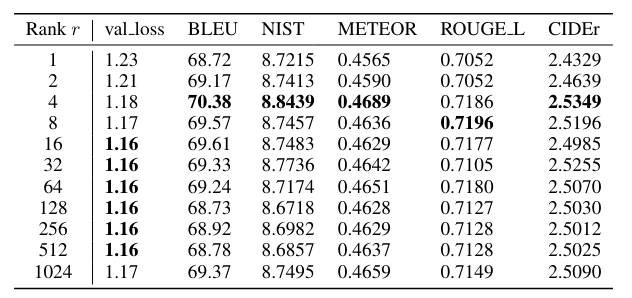

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

Add LoRA adapter layers/parameters to the original LLM to be trained.

In [ ]:
peft_model = get_peft_model(original_model,
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%


### 3.2 - Train PEFT Adapter

Define training arguments and create `Trainer` instance.

In [ ]:
output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=1,
    logging_steps=1,
    max_steps=1
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

In [ ]:
peft_trainer.train()

peft_model_path="./peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,51.000000


('./peft-dialogue-summary-checkpoint-local/tokenizer_config.json',
 './peft-dialogue-summary-checkpoint-local/special_tokens_map.json',
 './peft-dialogue-summary-checkpoint-local/tokenizer.json')

Load a fully trained PEFT model, previously trained on the full dataset on AWS SageMaker. Downloading the checkpoint of a PEFT model from the gdirve.

In [ ]:
!gdown --folder 1yULjubFpApAEi5yegV8jqOUyehGWYdvb

Retrieving folder contents
Processing file 1afWEZxC8smZa3tKO2gGN8WgR96vq4B2i adapter_config.json
Processing file 1r2OzTXJKLYssJrzMKBefPsjFv9K7tGm7 adapter_model.bin
Processing file 1kNsQX0FFFHXVY1mUvQENR_9TeaBgxsdN special_tokens_map.json
Processing file 1d2gGWcOJ8VstttTTK1-m10vxhngls0qO tokenizer_config.json
Processing file 1QVN9qDB2P4NzhJurL2gmzU9pJ87rG7rY tokenizer.json
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1afWEZxC8smZa3tKO2gGN8WgR96vq4B2i
To: /content/peft-dialogue-summary-checkpoint-from-gdrive/adapter_config.json
100% 334/334 [00:00<00:00, 1.05MB/s]
Downloading...
From: https://drive.google.com/uc?id=1r2OzTXJKLYssJrzMKBefPsjFv9K7tGm7
To: /content/peft-dialogue-summary-checkpoint-from-gdrive/adapter_model.bin
100% 14.2M/14.2M [00:00<00:00, 25.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kNsQX0FFFHXVY1mUvQENR_9TeaBgxsdN
To: /content/peft-dialogue-su

Check the size of this model which is much less than the original LLM:

In [ ]:
!ls -al ./peft-dialogue-summary-checkpoint-from-gdrive/adapter_model.bin

-rw-r--r-- 1 root root 14208525 May 22 10:38 ./peft-dialogue-summary-checkpoint-from-gdrive/adapter_model.bin


Prepare this model by adding an adapter to the original FLAN-T5 model. Here, we are setting `is_trainable=False` because the plan is only to perform inference with this PEFT model. If further training is required then we can set `is_trainable=True`.

In [ ]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base,
                                       './peft-dialogue-summary-checkpoint-from-gdrive/',
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

The number of trainable parameters will be `0` due to `is_trainable=False` setting:

In [ ]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 0
all model parameters: 251116800
percentage of trainable model parameters: 0.00%


### 3.3 - Evaluate the Model Qualitatively (Human Evaluation)

Make inferences for the same example as in above sections with the original model, fully fine-tuned and PEFT model.

In [ ]:
index = 200
dialogue = dataset['test'][index]['dialogue']
baseline_human_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')
print(dash_line)
print(f'PEFT MODEL: {peft_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
#Person1#: I'm thinking of upgrading my computer.
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
#Person1# suggests #Person2# upgrading #Person2#'s system, hardware, and CD-ROM drive. #Person2# thinks it's great.
---------------------------------------------------------------------------------------------------
PEFT MODEL: #Person1# recommends adding a painting program to #Person2#'s software and upgrading hardware. #Person2# also wants to upgrade the hardware because it's outdated now.


### 3.4 - Evaluate the Model Quantitatively (with ROUGE Metric)
Perform inferences for the sample of the test dataset (only 10 dialogues and summaries to save time).

In [ ]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    human_baseline_text_output = human_baseline_summaries[idx]

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    original_model_summaries.append(original_model_text_output)
    instruct_model_summaries.append(instruct_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries, peft_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries', 'peft_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,#Person1#: I need to take a dictation for you.,#Person1# asks Ms. Dawson to take a dictation ...,#Person1# asks Ms. Dawson to take a dictation ...
1,In order to prevent employees from wasting tim...,#Person1#: I need to take a dictation for you.,#Person1# asks Ms. Dawson to take a dictation ...,#Person1# asks Ms. Dawson to take a dictation ...
2,Ms. Dawson takes a dictation for #Person1# abo...,#Person1#: I need to take a dictation for you.,#Person1# asks Ms. Dawson to take a dictation ...,#Person1# asks Ms. Dawson to take a dictation ...
3,#Person2# arrives late because of traffic jam....,The traffic jam at the Carrefour intersection ...,#Person2# got stuck in traffic again. #Person1...,#Person2# got stuck in traffic and #Person1# s...
4,#Person2# decides to follow #Person1#'s sugges...,The traffic jam at the Carrefour intersection ...,#Person2# got stuck in traffic again. #Person1...,#Person2# got stuck in traffic and #Person1# s...
5,#Person2# complains to #Person1# about the tra...,The traffic jam at the Carrefour intersection ...,#Person2# got stuck in traffic again. #Person1...,#Person2# got stuck in traffic and #Person1# s...
6,#Person1# tells Kate that Masha and Hero get d...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Kate tells #Person2# Masha and Hero are gettin...
7,#Person1# tells Kate that Masha and Hero are g...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Kate tells #Person2# Masha and Hero are gettin...
8,#Person1# and Kate talk about the divorce betw...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Kate tells #Person2# Masha and Hero are gettin...
9,#Person1# and Brian are at the birthday party ...,"#Person1#: Happy birthday, Brian. #Person2#: I...",Brian's birthday is coming. #Person1# invites ...,Brian remembers his birthday and invites #Pers...


In [ ]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.24089921652421653, 'rouge2': 0.11769053708439897, 'rougeL': 0.22001958689458687, 'rougeLsum': 0.22134175465057818}
INSTRUCT MODEL:
{'rouge1': 0.41026607717457186, 'rouge2': 0.17840645241958838, 'rougeL': 0.2977022096267017, 'rougeLsum': 0.2987374187518165}
PEFT MODEL:
{'rouge1': 0.3725351062275605, 'rouge2': 0.12138811933618107, 'rougeL': 0.27620639623170606, 'rougeLsum': 0.2758134870822362}


Notice, that PEFT model results are not too bad, while the training process was much easier!

We have already computed ROUGE score on the full dataset, after loading the results from the `dialogue-summary-training-results.csv` file. Now, we can load the values for the PEFT model now and check its performance compared to other models.

In [ ]:
human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values
peft_model_summaries     = results['peft_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2334158581572823, 'rouge2': 0.07603964187010573, 'rougeL': 0.20145520923859048, 'rougeLsum': 0.20145899339006135}
INSTRUCT MODEL:
{'rouge1': 0.42161291557556113, 'rouge2': 0.18035380596301792, 'rougeL': 0.3384439349963909, 'rougeLsum': 0.33835653595561666}
PEFT MODEL:
{'rouge1': 0.40810631575616746, 'rouge2': 0.1633255794568712, 'rougeL': 0.32507074586565354, 'rougeLsum': 0.3248950182867091}


The results show less of an improvement over full fine-tuning, but the benefits of PEFT typically outweigh the slightly-lower performance metrics.

Calculate the improvement of PEFT over the original model:

In [ ]:
print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: 17.47%
rouge2: 8.73%
rougeL: 12.36%
rougeLsum: 12.34%


Now calculate the improvement of PEFT over a full fine-tuned model:

In [ ]:
print("Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(instruct_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL
rouge1: -1.35%
rouge2: -1.70%
rougeL: -1.34%
rougeLsum: -1.35%


**Here** we can observe a small percentage decrease in the ROUGE metrics vs. full fine-tuned. However, the training requires much less computing and memory resources (often just a single GPU).